## Chapter 10: Nonlinear Learning and Feature Engineering

# 10.3  Nonlinear Multi-Output Regression

In this Section we present a description of nonlinear feature engineering for multi-ouput regression first introduced [Section 5.6](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_6_Multi.html).  This mirrors what we have seen in the previous Section completely with one small but important difference: in the multi-output case we can choose to model each regression *separately*, employing one nonlinear model for output, *or jointly*, producing a single nonlinear model for all outputs simultaneously.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# import gridworld library - make sure this is executed prior to running any gridworld cell
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer()

# demos for this notebook
plotter = superlearn.multi_outupt_plotters

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

##  Modeling principles of linear multi-output regression

Recall that when dealing withi mulit-output regression (introduced in [Section 5.6](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_6_Multi.html)) we have $N$ dimensional input / $C$ dimensional output pairs $\left(\mathbf{x}_p,\,\mathbf{y}_p\right)$, and our joint linear model for all $C$ regressions takes the form

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{W}\right) =
\mathring{\mathbf{x}}^T\mathbf{W}^{\,}
\end{equation}

where the weight matrix $\mathbf{W}$ has dimension $\left(N+1\right)\times C$.  As discussed there, we can tune the parameters of this joint model *one column at a time* by solving each linear regression *independently*.  We can also tune the parameters of $\mathbf{W}$ *simultaneously* by minimizing an appropriate regression cost function over the entire matrix like e.g., the Least Square

\begin{equation}
 g\left(\mathbf{W}\right) = \frac{1}{P}\sum_{p=1}^{P} \left \Vert  \mathring{\mathbf{x}}_{p}^T \mathbf{W}   - \overset{\,}{\mathbf{y}}_{p}^{\,} \right \Vert_2^2.
 \end{equation}

However because this model is *linear* the results of either approach result in the same tuning of the parameters.

##  Modeling principles of nonlinear multi-output regression

With multi-output regression the move from linear to nonlinear modeling mirrors what we have seen in the previous Section completely - with one small but important wrinkle.  With $C$ regressions to perform we can choose to either produce $C$ *independent* nonlinear models or one *shared* nonlinear model for all $C$ regressions.  

<figure>
<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/sharing_architecture_regression.png' width="65%" height="65%" alt=""/>
</p>
<figcaption> <strong>Figure 1:</strong> <em> 
Nonlineaer multi-output regression: we can either solve each regression problem independently, employing a distinct nonlinearity per sub-problem (left panel) or use a *shared nonlinear architecture* in solving all problems *simultaneously*. 
</em>
</figcaption>
</figure>

If we choose the former approach - forming $C$ separate nonlinear models - each feature engineering / noonlinear regression is executed precisely as we have seen in previous the Section.  That is, for the $c^{th}$ regression problem we construct a model using (in general) $B_c$ nonlinear feature transformations as 

\begin{equation}
\text{model}_c\left(\mathbf{x},\Theta_c\right) = w_{c,0} + f_{1}\left(\mathbf{x}\right){w}_{c,1} +  f_{2}\left(\mathbf{x}\right){w}_{c,2} + \cdots + f_{B_c}\left(\mathbf{x}\right)w_{c,B_c}
\end{equation}



where $f_1,\,f_2,\,...\,f_{B_c}$ are nonlinear parameterized or unparameterized functions that can be chosen uniquely for the $c^{th}$ model, and $w_{c,0}$ through $w_{c,B_c}$ (along with any additional weights internal to the nonlinear functions) are represented in the weight set $\Theta_c$ and must be tuned properly.   To perform multi-output regression we can then - with nonlinear feature transformations chosen - tune each of the $C$ models above via the minimization of a proper regression cost like e.g., the Least Squares. 

With the latter approach to nonlinear multi-output regression - that is we engineer a *single set of nonlinear feature transfomations and share them among all $C$ regressions* -  we simply use *the same nonlinear features* for all $C$ models.  This is very often done to simplify the chores of nonlinear feature engineering and - as we will see - nonlinear feature *learning*.  if we choose the same set $B$ nonlinear features for all $C$ models the $c^{th}$ of which looks like

\begin{equation}
\text{model}_c\left(\mathbf{x},\Theta_c\right) = w_{c,0} + f_{1}\left(\mathbf{x}\right){w}_{c,1} +  f_{2}\left(\mathbf{x}\right){w}_{c,2} + \cdots + f_{B}\left(\mathbf{x}\right)w_{c,B}
\end{equation}

Note here while $\Theta_c$ contains both those weights from the linear combination $w_{c,0},\,...w_{c,B}$ as well as any weights internal to the feature transformatinos, the *only* parameters unique to this model alone are the linear combination weights (since every model shares any weights internal to the feature transformations).

Employing the same compact notation for our feature transformations introduced in Section [10.2.2](https://jermwatt.github.io/machine_learning_refined/notes/10_Nonlinear_intro/10_2_Regression.html) we can express each of these models more compactly as
 
\begin{equation}
\text{model}_c\left(\mathbf{x},\Theta_c\right) = \mathring{\mathbf{f}}_{\,}^T \mathbf{w}_c.
\end{equation}

<figure>
<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/10_2.png' width="85%"  alt=""/>
</p>
<figcaption> <strong>Figure:</strong> <em> 
(left) Linear multi-output regression. (middle) Nonlinear multi-output regression where each output uses its own distinct nonlinear feature transformation. (right) Nonlinear multi-output regression where both outputs use the same nonlinear feature transformation (a case of feature-sharing).
</em>
</figcaption>
</figure>

Alternatively we formulate them all in one model by stacking the linear combination weights from our $C$ nonlinear models from equation (3) into an $\left(N + 1\right) \times C$ array of the form

\begin{equation}
\mathbf{W}=\begin{bmatrix} 
w_{0,0}  &  w_{0,1}  &  w_{0,2}  & \cdots   &  w_{0,C-1}  \\
w_{1,0}  &  w_{1,1}  &  w_{1,2}  & \cdots  &   w_{1,C-1}  \\
w_{2,0}  &  w_{2,1}  &  w_{2,2}  & \cdots  &  w_{2,C-1}  \\
\,\,\, {\vdots}_{\,\,\,}  & {\vdots}_{\,\,\,}  &  {\vdots}_{\,\,\,}  &  \cdots   &    {\vdots}_{\,\,\,}    \\
w_{N,0}  &  w_{N,1} & w_{N,2}  &  \cdots  &  w_{N,C-1}  \\
\end{bmatrix}
\end{equation}

we can likewise express all $C$ models together in one singular model as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathring{\mathbf{f}}_{\,}^T \mathbf{W} 
\end{equation}

This of course is a direct generalization of the original linear model shown in equation (1).  Note here that the set $\Theta$ contains the linear combination weights $\mathbf{W}$ as well as any parameters internal to our feature transformations.  To tune the weights of our joint model we minnimize an appropriate regression cost over the parameters in $\Theta$ like e.g., the Least Squares

\begin{equation}
 g\left(\Theta\right) = \frac{1}{P}\sum_{p=1}^{P} \left \Vert  \mathring{\mathbf{f}}_{p}^T \mathbf{W}   - \overset{\,}{\mathbf{y}}_{p}^{\,} \right \Vert_2^2.
 \end{equation}

If these feature transformations contain *no internal parameters*, e.g., if they are polynomial functions, then since our model decomposes nicely into a linear combination of each of the $C$ individual regression models each can be tuned separately.  However when employing *parameterized* features (like e.g., neural networks) then we the joint cost function does not decompose over each regressor and we *must* tune all of our model parameters *jointly*, that is learn all $C$ regressions *simultaneously*.  

## A feature engineering example

Given the additional number of regressions here, determining features by visual analysis is more challenging than the basic instance of regression detailed in the previous Section.  Here we provide one relatively simple example of this sort of feature engineering. 

#### <span style="color:#a50e3e;">Example 1. </span>  Tuning multiple regressions simultaneously

Below we plot a $C = 2$ multi-ouptput regression dataset, the first pairs are shown in the left panel while the second pairs are shown in the right.  Both instances appear to be *sinusoidal* in nature, with each having its own unique shape. 

<IPython.core.display.Javascript object>


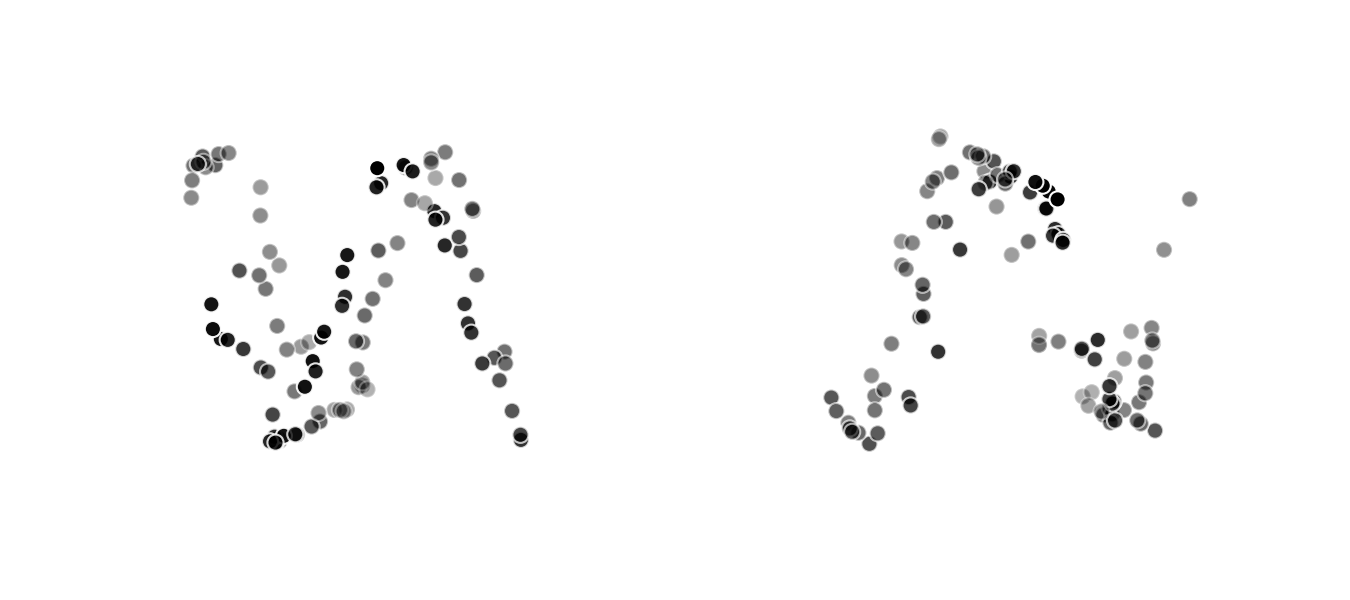

In [2]:
## This code cell will not be shown in the HTML version of this notebook
csvname = datapath + 'multiple_sine_waves.csv'
data = np.loadtxt(csvname,delimiter=',')
x = data[:2,:]
y = data[2:,:]

# plot
plotter.plot_data(x,y,view1 = [6,-10],view2 = [11,-62])

To model both regressions simultaneously we will use $B = 2$ parameterized sinusoidal feature transformations

\begin{equation}
\begin{array}
\
f_1\left(\mathbf{x}\right) = \text{sin}\left(w_{1,0} + w_{1,1}x_1 + w_{1,2}x_2\right) \\
f_2\left(\mathbf{x}\right) = \text{sin}\left(w_{2,0} + w_{2,1}x_1 + w_{2,2}x_2\right) \\
\end{array}
\end{equation}

Fitting this set of nonlinear features jointly to both regression problems above (using gradient descent) results in the fits shown below - both of which are quite good.

<IPython.core.display.Javascript object>


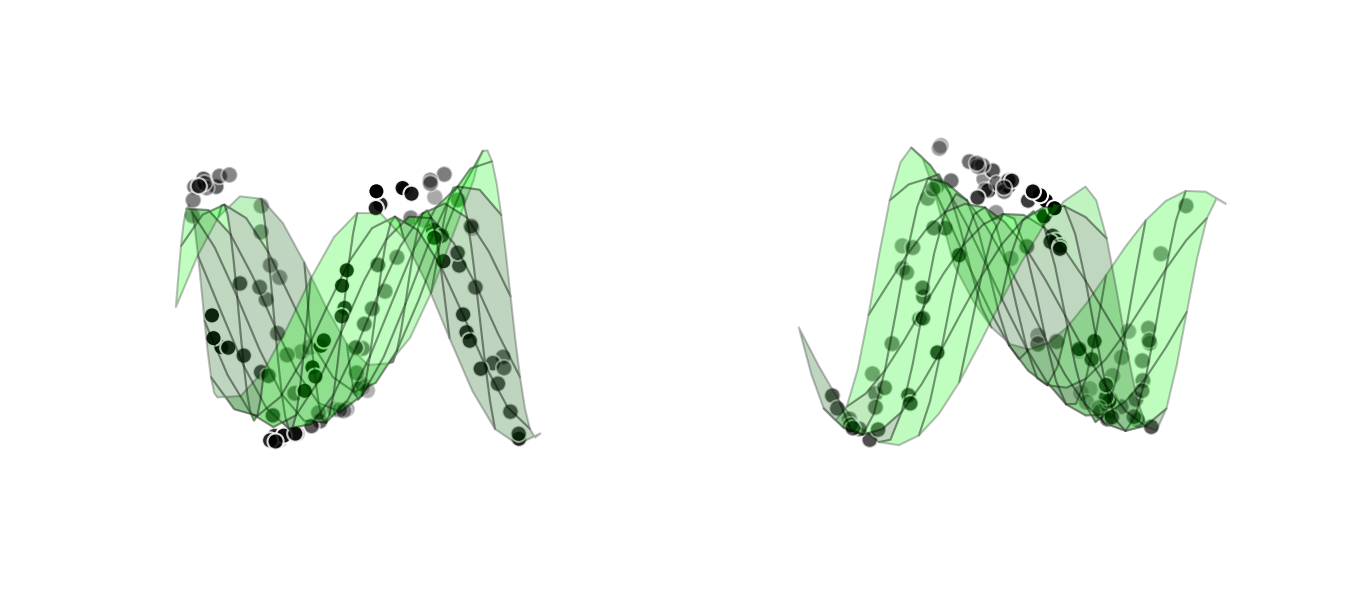

In [3]:
## This code cell will not be shown in the HTML version of this notebook
# feature transformation
def feature_transforms(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return np.sin(a).T

# an implementation of our model employing a nonlinear feature transformation
def model(x,w):    
    # feature transformation 
    f = feature_transforms(x,w[0])
    
    # compute linear combination and return
    a = w[1][0] + np.dot(f.T,w[1][1:])
    return a.T

# an implementation of the least squares cost function for linear regression
def least_squares(w):    
    # compute the least squares cost
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(np.size(y))

# setup and run optimization
g = least_squares; 
num_feats = 2
scale = 1
w = [scale*np.random.randn(3,num_feats), scale*np.random.randn(num_feats + 1,2)]
max_its = 2000;
alpha_choice = 10**(0);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# # plot history
# static_plotter.plot_cost_histories([cost_history],start = 0,points = False,labels = ['run 1'])

# determine best weights - based on lowest cost value attained
ind = np.argmin(cost_history)
w_best = weight_history[ind]

# form predictor
predictor = lambda x: model(x,w_best)

# plot data with predictions
plotter.plot_regressions(x,y,predictor,view1 = [6,-10],view2 = [11,-62])

## Implementing joint nonlinear multi-output regression in `Python`

As with the linear case, detailed in [Section 5.6.3](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_6_Multi.html), here likewise we can piggy-back on our general `Pythonic` implementation of nonlinear regression introduced in [Section 10.2.4](https://jermwatt.github.io/machine_learning_refined/notes/10_Nonlinear_intro/10_2_Regression.html) and employ precisely the same model and cost function implementation as used in the single-output case.  The only difference here is in how how we define our feature transformations and the dimension of our matrix of linear combination weights.